# Network Graphs

The aim of this notebook is to generate graphs based do two different approaches:

1. **embedding approach**: we used e5-large model to generate embeddings of size 1024 from plots (see [embeddings.ipynb](embeddings.ipynb)), calculated similarities (see [similarities.ipynb](similarities.ipynb)) and based on similarities generate graphs;
2. **genre approach**: we picked genres and themes and let bart-large model to predict the probabilities of belonging to a genre/theme (see [embeddings.ipynb](embeddings.ipynb)) and calculated once again similarities (see [similarities.ipynb](similarities.ipynb)).
3. **raw genres approach**: we create the graph based on the already defined genres of the movies, an edge is created if two movies share the same genre.

## Imports

In [12]:
import itertools
import pickle

import pandas as pd
import networkx as nx

import ast
import math

import os
import sys
sys.path.append(os.path.abspath('..'))

from scripts.helpers import get_similarities_from_json

## Prepare the Data

In [2]:
# get the processed df
df = pd.read_csv('../data/processed/preprocessed.csv', index_col=0)
df.set_index('wikipedia_id', inplace=True)
print(df.shape)
df.head(5)

(22394, 9)


,name,release_year,rating,num_votes,plot,freebase_id,languages,countries,genres
wikipedia_id,,,,,,,,,
10109752,Miss Jerry,1894.0,5.3,207,After finding out that her father is suffering...,/m/02q23xk,['Silent film'],['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-..."
28703057,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],['Sports']
142995,The Story of the Kelly Gang,1906.0,6.0,855,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,['English Language'],['Australia'],"['Crime Fiction', 'Silent film', 'Biography', ..."
32986669,Robbery Under Arms,1907.0,4.3,25,Key scenes of the film included the branding o...,/m/04p7yxx,['Silent film'],['Australia'],"['Silent film', 'Drama']"
32987200,"Captain Midnight, the Bush King",1911.0,5.4,18,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,['Silent film'],[],['Silent film']


## Embedding Approach

In [3]:
DECADE = 1920  # the decade we're interested in

# get the similarities as dict and extract list of unique movies
similarity_dict = get_similarities_from_json(DECADE)
movies = list(set(itertools.chain(*similarity_dict.keys())))

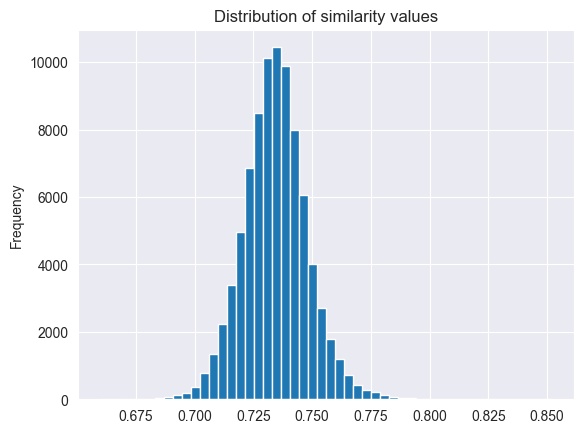

In [4]:
# check the distribution of similarity values
similarity_values = list(similarity_dict.values())
_ = pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [5]:
# show descriptive statistics
descriptive_stats = pd.Series(similarity_values).describe()
descriptive_stats

count    85078.000000
mean         0.734374
std          0.013782
min          0.659927
25%          0.725649
50%          0.734179
75%          0.742603
max          0.851925
dtype: float64

75th percentile of the similarities will be used as the threshold for creating an edge between the nodes.

In [6]:
similarity_threshold = descriptive_stats['75%'] 

# generate nodes df and add all the pairs with similarity
similarity_mat = [[key[0], key[1], value] for key, value in similarity_dict.items()]
nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight']) 

# filter based on 75th percentile
nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [7]:
G.number_of_nodes(), G.number_of_edges()

(407, 21270)

For the analysis, we need betweenness and degree, plus few other attributes will be added to the graph.

In [13]:
def complete_graph(G, df):
    # add name as an attribute
    names = dict((id_, df.loc[int(id_)]['name']) for id_ in G.nodes)
    nx.set_node_attributes(G, name='name', values=names)

    # add wikipedia id as an attribute
    names = dict((id_, int(id_)) for id_ in G.nodes)
    nx.set_node_attributes(G, name='wikipedia_id', values=names)

    # calculate the betweenness centrality
    betweenness = nx.betweenness_centrality(G)
    nx.set_node_attributes(G, name='betweenness', values=betweenness)

    # calculate the log betweenness centrality
    log_betweenness = {node: math.log(centrality + 1e-5) for node, centrality in betweenness.items()}
    nx.set_node_attributes(G, name='log_betweenness', values=log_betweenness)

    # calculate degree for each node
    degrees = dict(nx.degree(G))
    nx.set_node_attributes(G, name='degree', values=degrees)

    # add movie rating
    ratings_dict = dict((id_, df.loc[int(id_)]['rating']) for id_ in G.nodes)
    nx.set_node_attributes(G, name='rating', values=ratings_dict)

    # add release year
    date_dict = dict((id_, df.loc[int(id_)]['release_year']) for id_ in G.nodes)
    nx.set_node_attributes(G, name="release_year", values=date_dict)

# Add the necessary attributes to the graph
complete_graph(G, df)

Save the graph with all the necessary attributes to pickle

In [14]:
with open(f'../data/graphs/embedding/{DECADE}s.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

## Genre Approach

As we've previously computed the embeddings and the similarities for the genre approach, computing the graph has the same approach.

In [4]:
DECADE = 1920  # the decade we're interested in

# get the similarities as dict and extract list of unique movies
similarity_dict = get_similarities_from_json(DECADE, approach='custom_genres')
movies = list(set(itertools.chain(*similarity_dict.keys())))

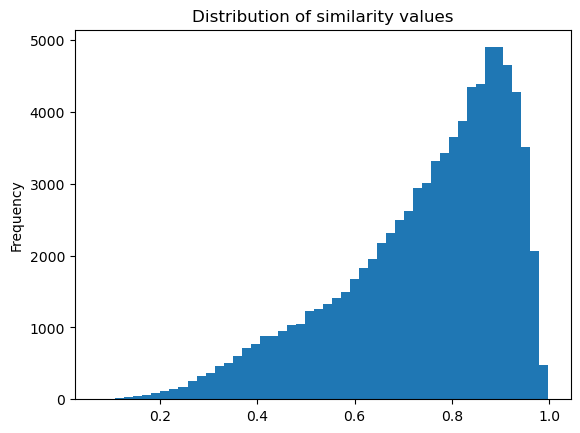

In [5]:
# check the distribution of similarity values
similarity_values = list(similarity_dict.values())
_ = pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [6]:
# show descriptive statistics
descriptive_stats = pd.Series(similarity_values).describe()
descriptive_stats

count    85078.000000
mean         0.743754
std          0.173489
min          0.071879
25%          0.641983
50%          0.786115
75%          0.881243
max          0.997671
dtype: float64

In [7]:
similarity_threshold = descriptive_stats['75%'] 

# generate nodes df and add all the pairs with similarity
similarity_mat = [[key[0], key[1], value] for key, value in similarity_dict.items()]
nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight']) 

# filter based on 75th percentile
nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [8]:
G.number_of_nodes(), G.number_of_edges()

(410, 21270)

In [ ]:
# Add the necessary attributes to the graph
complete_graph(G, df)

Save the graph with all the necessary attributes to pickle

In [ ]:
with open(f'../data/graphs/embedding/{DECADE}s.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

## Raw Genres Approach

We make a list for each genres with all the movies having that genre, then we create an edge between each pair of movies that share at least one genre by connecting each movie in the list to all the other movies in the list.

In [10]:
# Pandas stores lists as strings, so we need to convert it back to list
df['genres'] = df['genres'].apply(ast.literal_eval)

In [ ]:
for decade in range(1910, 2020, 10):
  print(f'Solving for decade: {decade}')
  decade_df = df[(df.release_year >= decade) & (df.release_year < decade + 10)].copy()

  G = nx.Graph()

  # Create a dictionary to hold movies by genre
  genre_dict = {}

  # Iterate over each movie and add it to the genre dictionary
  for idx, row in decade_df.iterrows():
      for genre in row['genres']:
          if genre not in genre_dict:
              genre_dict[genre] = []
          genre_dict[genre].append(row.name)

  # Now create edges between movies with shared genres
  for genre, movies in genre_dict.items():
      # itertools.combinations creates all unique pairs
      for movie_1, movie_2 in itertools.combinations(movies, 2):
          G.add_edge(movie_1, movie_2)

  print(f'Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')

  # Add the necessary attributes to the graph
  complete_graph(G, df)

  # Show the degree distribution
  degrees = [G.degree(n) for n in G.nodes()]
  plt.hist(degrees, bins=100)
  plt.title(f"Degree distribution for {decade}s")

  print(f"Number of nodes: {len(G.nodes())}")

  with open(f'data/raw/graphs/{decade}s.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

  del G # free up memory faster so that there aren't issues with Colab